In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')
from datetime import date,datetime, timedelta
from sklearn.model_selection import train_test_split

In [2]:
speed = pd.read_csv('train.csv',index_col='date',parse_dates=['date'],dayfirst = True)
speed2 = pd.read_csv('test.csv',index_col='date',parse_dates=['date'],dayfirst = True)
#speed = pd.read_csv('datacleaned_linear.csv',index_col='date',parse_dates=['date'])

In [4]:
speed.head(15)

,id,speed
date,,
2017-01-01 00:00:00,0,43.002930
2017-01-01 01:00:00,1,46.118696
2017-01-01 02:00:00,2,44.294158
2017-01-01 03:00:00,3,41.067468
2017-01-01 04:00:00,4,46.448653
2017-01-01 05:00:00,5,46.797766
2017-01-01 06:00:00,6,44.404925
2017-01-01 07:00:00,7,45.255897
2017-01-01 08:00:00,8,45.680859


In [5]:
speed = speed[['speed']]
#speed.head(50)
speed.head(15)

,speed
date,
2017-01-01 00:00:00,43.002930
2017-01-01 01:00:00,46.118696
2017-01-01 02:00:00,44.294158
2017-01-01 03:00:00,41.067468
2017-01-01 04:00:00,46.448653
2017-01-01 05:00:00,46.797766
2017-01-01 06:00:00,44.404925
2017-01-01 07:00:00,45.255897
2017-01-01 08:00:00,45.680859


In [6]:
speed_train, speed_test = train_test_split(speed,test_size = 0.1)
#train_X,test_X,train_y,test_y = train_test_split(train_data,train_target,test_size=0.3,random_state=5)

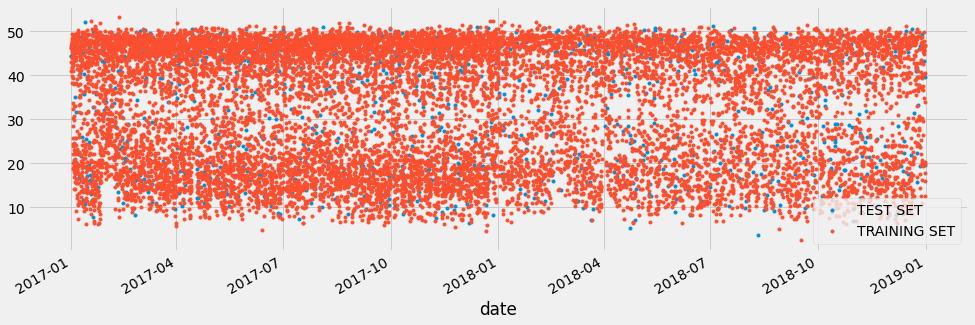

In [8]:
_ = speed_test \
    .rename(columns={'speed': 'TEST SET'}) \
    .join(speed_train.rename(columns={'speed': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), style='.')

In [9]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    #df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [10]:
X_train, y_train = create_features(speed_train, label='speed')
X_test, y_test = create_features(speed_test, label='speed')
X_test.tail(50)

<ipython-input-9-5cfe5c43e116>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df.index
<ipython-input-9-5cfe5c43e116>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df['date'].dt.hour
<ipython-input-9-5cfe5c43e116>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

,hour,dayofweek,quarter,month,year,dayofyear,weekofyear
date,,,,,,,
2017-02-28 10:00:00,10,1,1,2,2017,59,9
2017-05-23 09:00:00,9,1,2,5,2017,143,21
2017-04-25 21:00:00,21,1,2,4,2017,115,17
2017-01-21 13:00:00,13,5,1,1,2017,21,3
2018-06-06 00:00:00,0,2,2,6,2018,157,23
2017-03-10 16:00:00,16,4,1,3,2017,69,10
2018-04-04 23:00:00,23,2,2,4,2018,94,14
2017-08-12 07:00:00,7,5,3,8,2017,224,32
2018-10-15 13:00:00,13,0,4,10,2018,288,42


In [14]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=True) # Change verbose to True if you want to see it train

[0]	validation_0-rmse:24.76667	validation_1-rmse:24.83151
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:17.66130	validation_1-rmse:17.72606
[2]	validation_0-rmse:12.76069	validation_1-rmse:12.82176
[3]	validation_0-rmse:9.46918	validation_1-rmse:9.51743
[4]	validation_0-rmse:7.31371	validation_1-rmse:7.34382
[5]	validation_0-rmse:5.93323	validation_1-rmse:5.96045
[6]	validation_0-rmse:5.08728	validation_1-rmse:5.10687
[7]	validation_0-rmse:4.57443	validation_1-rmse:4.59238
[8]	validation_0-rmse:4.28349	validation_1-rmse:4.29728
[9]	validation_0-rmse:4.11815	validation_1-rmse:4.13720
[10]	validation_0-rmse:4.02248	validation_1-rmse:4.04852
[11]	validation_0-rmse:3.93413	validation_1-rmse:3.96860
[12]	validation_0-rmse:3.84802	validation_1-rmse:3.89237
[13]	validation_0-rmse:3.78622	validation_1-rmse:3.83026
[14]	validation_0-rmse:3.74313	validation_1-rms

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

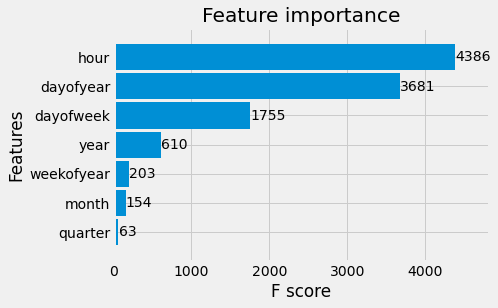

In [15]:
_ = plot_importance(reg, height=0.9)

In [16]:
speed_test['speed_Prediction'] = reg.predict(X_test)
speed_all = pd.concat([speed_test, speed_train], sort=False)

<ipython-input-16-a12cd454c608>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  speed_test['speed_Prediction'] = reg.predict(X_test)


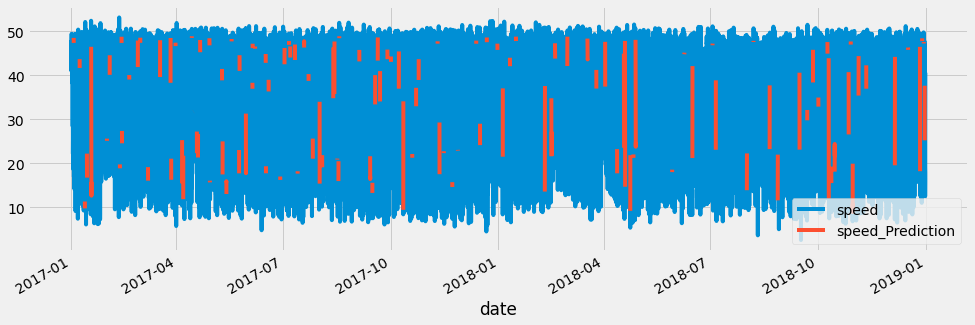

In [17]:
_ = speed_all[['speed','speed_Prediction']].plot(figsize=(15, 5))

In [18]:
speed_test

,speed,date,hour,dayofweek,quarter,month,year,dayofyear,weekofyear,speed_Prediction
date,,,,,,,,,,
2018-02-06 19:00:00,20.395600,2018-02-06 19:00:00,19,1,1,2,2018,37,6,19.274252
2017-06-27 14:00:00,11.937432,2017-06-27 14:00:00,14,1,2,6,2017,178,26,15.705913
2018-09-17 12:00:00,29.554324,2018-09-17 12:00:00,12,0,3,9,2018,260,38,27.654463
2017-10-02 20:00:00,38.300402,2017-10-02 20:00:00,20,0,4,10,2017,275,40,36.537338
2017-04-15 23:00:00,39.983918,2017-04-15 23:00:00,23,5,2,4,2017,105,15,41.669094
...,...,...,...,...,...,...,...,...,...,...
2018-07-01 13:00:00,41.811147,2018-07-01 13:00:00,13,6,3,7,2018,182,26,40.309658
2017-07-03 00:00:00,48.742371,2017-07-03 00:00:00,0,0,3,7,2017,184,27,46.953350
2017-01-14 05:00:00,45.863401,2017-01-14 05:00:00,5,5,1,1,2017,14,2,46.444023


In [19]:
X_test, y_test = create_features(speed2, label='id')
X_test

,hour,dayofweek,quarter,month,year,dayofyear,weekofyear
date,,,,,,,
2018-01-01 02:00:00,2,0,1,1,2018,1,1
2018-01-01 05:00:00,5,0,1,1,2018,1,1
2018-01-01 07:00:00,7,0,1,1,2018,1,1
2018-01-01 08:00:00,8,0,1,1,2018,1,1
2018-01-01 10:00:00,10,0,1,1,2018,1,1
...,...,...,...,...,...,...,...
2018-12-31 17:00:00,17,0,4,12,2018,365,1
2018-12-31 19:00:00,19,0,4,12,2018,365,1
2018-12-31 21:00:00,21,0,4,12,2018,365,1


In [20]:

#df.sort_index(ascending=False)
X_test.head(10)

,hour,dayofweek,quarter,month,year,dayofyear,weekofyear
date,,,,,,,
2018-01-01 02:00:00,2,0,1,1,2018,1,1
2018-01-01 05:00:00,5,0,1,1,2018,1,1
2018-01-01 07:00:00,7,0,1,1,2018,1,1
2018-01-01 08:00:00,8,0,1,1,2018,1,1
2018-01-01 10:00:00,10,0,1,1,2018,1,1
2018-01-01 16:00:00,16,0,1,1,2018,1,1
2018-01-01 18:00:00,18,0,1,1,2018,1,1
2018-01-02 01:00:00,1,1,1,1,2018,2,1
2018-01-02 02:00:00,2,1,1,1,2018,2,1


,id,speed
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
3499,3499,0
3500,3500,0
3501,3501,0
3502,3502,0


In [42]:
speed_testing = reg.predict(X_test)
#pjme_test['MW_Prediction'] = reg.predict(X_test)

In [46]:
speed_testing = pd.DataFrame(speed_testing)
speed_testing.head(50)

,0
0,48.369568
1,47.804798
2,38.055412
3,28.797564
4,40.179062
5,22.808340
6,17.488136
7,49.330811
8,47.586895
9,29.423784


In [54]:
Submission= pd.read_csv('sampleSubmission.csv')
Submission

,id,speed
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
3499,3499,0
3500,3500,0
3501,3501,0
3502,3502,0


In [55]:
Submission['speed'] = speed_testing
Submission

,id,speed
0,0,48.369568
1,1,47.804798
2,2,38.055412
3,3,28.797564
4,4,40.179062
...,...,...
3499,3499,16.229874
3500,3500,29.550091
3501,3501,44.009270
3502,3502,43.444870


In [60]:
Submission.to_csv('kaggle_xgboost_try.csv',index=False,header = True)